In [24]:
import polars as pl

In [25]:
data = pl.read_csv("data/aus_sports_betting.csv")

In [26]:
# clean data

# Drop unimportant columns
# These need to be wrapped in try-catch in case the cell is rerun
try:
    data = data.drop(["Date", "Notes"])
except pl.exceptions.ColumnNotFoundError:
    pass

# replace all "Y" strings with 1
data = data.with_columns([
    pl.when(pl.col(col) == "Y").then(1).otherwise(pl.col(col)).alias(col)
    for col in data.columns if data[col].dtype == pl.Utf8
])
data = data.with_columns([
    pl.col(col).fill_null(0).alias(col) for col in data.columns if data[col].dtype == pl.Utf8
])
# drop rows with null values, as null values here means missing important data
data = data.drop_nulls()

# convert Overtime? Playoff Game? and Neutral Venue? to boolean values
data = data.with_columns([
    pl.col(col).cast(pl.Int8).alias(col) for col in ["Overtime?", "Playoff Game?", "Neutral Venue?"]
])

data = data.drop(["Home Team", "Away Team"])

TARGET = "Home Team Win"
# Add a Home Team Win column that is either 1 or 0 based on if Home Score is greater than Away Score
data = data.with_columns(
    (pl.col("Home Score") > pl.col("Away Score")).cast(pl.Int8).alias(TARGET)
)
# # Add a column called Over Hit that is 1 if Home Score + Away Score > Total Score Close
# data = data.with_columns(
#     (pl.col("Home Score") + pl.col("Away Score") > pl.col("Total Score Close")).cast(pl.Int8).alias("Over Hit")
# )
# # Add a column called Home Team Cover that is 1 if Home Score - Away Score > Home Spread Close
# data = data.with_columns(
#     (pl.col("Away Score") - pl.col("Home Score") < pl.col("Home Line Close")).cast(pl.Int8).alias("Home Team Cover")
# )
# # Add a column called Away Team Cover that is 1 if Away Score - Home Score > Away Spread Close
# data = data.with_columns(
#     (pl.col("Home Score") - pl.col("Away Score") < pl.col("Away Line Close")).cast(pl.Int8).alias("Away Team Cover")
# )

# drop things only known after the game, like Home Score, Away Score, and Overtime?
data = data.drop(["Home Score", "Away Score", "Overtime?"])

data

Playoff Game?,Neutral Venue?,Home Odds Open,Home Odds Min,Home Odds Max,Home Odds Close,Away Odds Open,Away Odds Min,Away Odds Max,Away Odds Close,Home Line Open,Home Line Min,Home Line Max,Home Line Close,Away Line Open,Away Line Min,Away Line Max,Away Line Close,Home Line Odds Open,Home Line Odds Min,Home Line Odds Max,Home Line Odds Close,Away Line Odds Open,Away Line Odds Min,Away Line Odds Max,Away Line Odds Close,Total Score Open,Total Score Min,Total Score Max,Total Score Close,Total Score Over Open,Total Score Over Min,Total Score Over Max,Total Score Over Close,Total Score Under Open,Total Score Under Min,Total Score Under Max,Total Score Under Close,Home Team Win
i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8
1,1,2.1,2.0,2.15,2.0,1.77,1.73,1.83,1.83,2.0,1.0,2.0,1.0,-2.0,-2.0,-1.0,-1.0,1.91,1.87,1.91,1.91,1.91,1.91,1.91,1.91,49.5,48.5,49.5,48.5,1.91,1.87,1.91,1.91,1.91,1.87,1.91,1.91,1
1,0,1.8,1.73,1.87,1.87,2.05,1.95,2.1,1.95,-1.5,-2.0,-1.0,-1.0,1.5,1.0,2.0,1.0,1.91,1.87,1.91,1.91,1.91,1.91,1.91,1.91,48.5,47.5,49.5,49.5,1.91,1.91,1.91,1.91,1.91,1.91,1.91,1.91,1
1,0,1.4,1.31,1.45,1.34,3.05,2.8,3.4,3.35,-5.5,-6.0,-4.5,-6.0,5.5,4.5,6.0,6.0,1.91,1.87,1.91,1.91,1.91,1.91,1.91,1.91,48.0,46.5,48.0,47.0,1.91,1.91,1.91,1.91,1.91,1.91,1.91,1.91,1
1,0,1.87,1.83,2.05,2.05,1.95,1.8,1.95,1.8,-1.0,-1.0,1.5,1.5,1.0,-1.5,1.0,-1.5,1.91,1.91,1.91,1.91,1.91,1.91,1.91,1.91,51.5,51.5,52.0,52.0,1.91,1.87,1.91,1.91,1.91,1.87,1.91,1.91,1
1,0,1.36,1.29,1.38,1.29,3.25,3.1,3.7,3.7,-6.0,-7.0,-5.5,-7.0,6.0,5.5,7.0,7.0,2.0,1.91,1.87,1.91,1.83,1.95,1.91,1.91,43.5,42.0,44.0,43.5,1.91,1.87,1.91,1.91,1.91,1.87,1.91,1.91,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,1.43,1.34,1.43,1.36,3.1,3.05,3.56,3.46,-5.0,-6.5,-5.0,-6.5,5.0,5.0,6.5,6.5,1.95,1.91,1.97,1.93,1.95,1.93,2.0,1.98,39.5,39.5,41.0,41.0,1.92,1.92,1.98,1.95,1.99,1.99,2.0,1.95,1
0,0,1.2,1.18,1.21,1.19,5.23,5.08,5.54,5.35,-10.0,-10.5,-10.0,-10.0,10.0,10.0,10.5,10.0,1.91,1.93,2.02,2.02,2.0,1.88,1.98,1.88,53.0,48.5,53.0,49.0,1.95,1.91,1.99,1.91,1.95,2.0,1.95,2.0,1
0,0,1.37,1.32,1.42,1.41,3.39,3.14,3.73,3.16,-6.0,-7.0,-5.5,-5.5,6.0,5.5,7.0,5.5,1.92,1.97,1.95,1.93,1.99,1.95,1.93,1.97,40.0,40.0,41.5,41.5,1.85,1.85,1.97,1.94,2.06,2.06,2.0,1.96,1


In [27]:
import torch
import torch.nn as nn

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [28]:
class SportsBettingModel(nn.Module):
    def __init__(self, num_features: int) -> None:
        super(SportsBettingModel, self).__init__()
        self.fc1 = nn.Linear(num_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        # self.fc4 = nn.Linear(16, 1)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        # x = self.fc4(x)
        return self.sigmoid(x)

In [29]:
from sklearn.model_selection import train_test_split

# Let's try building a model to predict a target value
features = data.drop(TARGET).to_numpy()
labels = data.select(pl.col(TARGET)).to_numpy()

features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

X_train = X_train.to(device)
X_val = X_val.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_val = y_val.to(device)
y_test = y_test.to(device)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
model = SportsBettingModel(num_features=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

X_train shape: torch.Size([2107, 38]), y_train shape: torch.Size([2107, 1])
X_test shape: torch.Size([452, 38]), y_test shape: torch.Size([452, 1])


SportsBettingModel(
  (fc1): Linear(in_features=38, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [30]:
import typing

def train_model(model: nn.Module, epochs: int = 1000) -> typing.Tuple[typing.List[float], typing.List[float]]:
    training_loss = []
    validation_loss = []
    min_val_loss = 1_000_000
    consecutive_epochs_without_new_min_val_loss = 0
    for epoch in range(epochs):
        if consecutive_epochs_without_new_min_val_loss >= 25:
             return training_loss, validation_loss
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            model.eval()
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            if val_loss.item() < min_val_loss:
                min_val_loss = val_loss.item()
                consecutive_epochs_without_new_min_val_loss = 0
            else:
                consecutive_epochs_without_new_min_val_loss += 1
                 
            validation_loss.append(val_loss.item())
        if epoch % 10 == 0:
                print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    return training_loss, validation_loss

In [31]:
import typing
import matplotlib.pyplot as plt


def plot_losses(train_loss: typing.List[float], val_loss: typing.List[float]) -> None:
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Epoch [0/1000], Loss: 0.9830, Val Loss: 0.7290
Epoch [10/1000], Loss: 0.6993, Val Loss: 0.6415
Epoch [20/1000], Loss: 0.6830, Val Loss: 0.6279
Epoch [30/1000], Loss: 0.6416, Val Loss: 0.6295
Epoch [40/1000], Loss: 0.6363, Val Loss: 0.6204
Epoch [50/1000], Loss: 0.6207, Val Loss: 0.6195
Epoch [60/1000], Loss: 0.6224, Val Loss: 0.6195
Epoch [70/1000], Loss: 0.6190, Val Loss: 0.6191
Epoch [80/1000], Loss: 0.6183, Val Loss: 0.6193


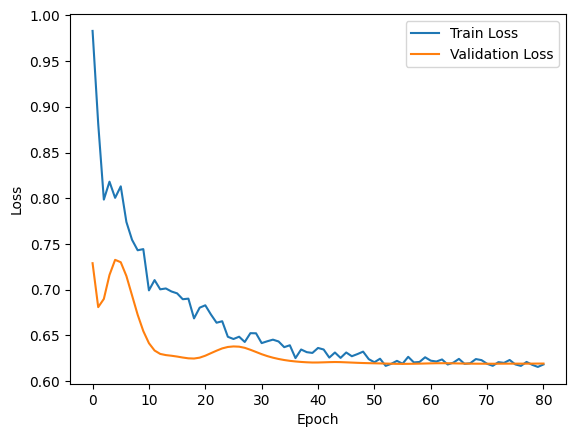

In [32]:
train_loss, val_loss = train_model(model, epochs=1000)
plot_losses(train_loss, val_loss)

In [33]:
# test the model
def test_model(model: nn.Module, X_test: torch.Tensor, y_test: torch.Tensor) -> float:
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()
        accuracy = (predicted == y_test).float().mean().item()
    return accuracy

accuracy = test_model(model, X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6283


In [34]:
def always_take_favorite(X_test) -> torch.Tensor:
    """
    A simple baseline model that always predicts the favorite team to win.
    This is a naive approach and should be used for comparison purposes only.
    """
    # Assuming the fifth column is the Home Team's odds, we predict 1 if Home Team's odds are lower (favorite)
    return (X_test[:, 5] < X_test[:, 9]).float().to(device)

In [35]:
train_favorite_predictions = always_take_favorite(X_train)
val_favorite_predictions = always_take_favorite(X_val)
test_favorite_predictions = always_take_favorite(X_test)
train_favorite_accuracy = (train_favorite_predictions.cpu().numpy().flatten() == y_train.cpu().numpy().flatten()).mean()
val_favorite_accuracy = (val_favorite_predictions.cpu().numpy().flatten() == y_val.cpu().numpy().flatten()).mean()
test_favorite_accuracy = (test_favorite_predictions.cpu().numpy().flatten() == y_test.cpu().numpy().flatten()).mean()
print(f"Always Take Favorite Train Accuracy: {train_favorite_accuracy:.4f}")
print(f"Always Take Favorite Validation Accuracy: {val_favorite_accuracy:.4f}")
print(f"Always Take Favorite Test Accuracy: {test_favorite_accuracy:.4f}")

Always Take Favorite Train Accuracy: 0.6720
Always Take Favorite Validation Accuracy: 0.6630
Always Take Favorite Test Accuracy: 0.6261


Looks like Vegas knows best after all. At least, there doesn't seem to be discernible patterns from Vegas lines alone that indicate patterns of when they're wrong. Let's see if we can instead build a model to predict when Vegas is correct

In [36]:
# add a Vegas Correct column where it is 1 if Home Spread Close is negative and Home Team Win is 1
# data = data.with_columns(
#     (
#         (pl.col("Home Line Close") < 0) & (pl.col("Home Team Win") == 1) | (pl.col("Home Line Close") > 0) & (pl.col("Home Team Win") == 0)
#     ).cast(pl.Int8).alias("Vegas Correct")
# )
data = data.with_columns(
    (
        (pl.col("Home Odds Close") < pl.col("Away Odds Close")) & (pl.col("Home Team Win") == 1) |
        (pl.col("Home Odds Close") > pl.col("Away Odds Close")) & (pl.col("Home Team Win") == 0)
    ).alias("Vegas Correct").cast(pl.Int8)
)
# # count how many 1s and 0s are in Vegas Correct
# vegas_correct_counts = data.select(
#     pl.col("Vegas Correct").value_counts()
# )
# # print the counts
# print(vegas_correct_counts)
# import numpy as np


# data = data.with_columns(
#         (pl.col("Home Odds Close") < pl.col("Away Odds Close")).cast(pl.Int8).alias("Home Odds Favorite"),
#     )
# home_odds_favorite = data.select(pl.col("Home Odds Favorite")).to_series().to_numpy()
# home_team_win = data.select(pl.col("Home Team Win")).to_series().to_numpy()
# # Calculate the accuracy of the Home Odds Favorite prediction
# correct_prediction_indices = home_odds_favorite == home_team_win
# print(np.count_nonzero(correct_prediction_indices))
# print(np.count_nonzero(correct_prediction_indices - 1))
# vegas_correct_single_if = (home_odds_favorite == home_team_win).astype(int)
# vegas_correct_double_if = data.select(pl.col("Vegas Correct")).to_series().to_numpy().astype(int)
# two_vegas_correct = vegas_correct_single_if == data.select(pl.col("Vegas Correct")).to_series().to_numpy().astype(int)
# print("\n\n\n")
# print(data.row(314))
# print(vegas_correct_single_if[314])
# print(vegas_correct_double_if[314])
# print(np.argwhere(two_vegas_correct == False))
# # print(f"Home Odds Favorite prediction accuracy: {accuracy:.2%}")

Epoch [0/1000], Loss: 0.6984, Val Loss: 0.6444
Epoch [10/1000], Loss: 0.6463, Val Loss: 0.6238
Epoch [20/1000], Loss: 0.6260, Val Loss: 0.6151
Epoch [30/1000], Loss: 0.6236, Val Loss: 0.6133
Epoch [40/1000], Loss: 0.6273, Val Loss: 0.6143
Epoch [50/1000], Loss: 0.6226, Val Loss: 0.6147


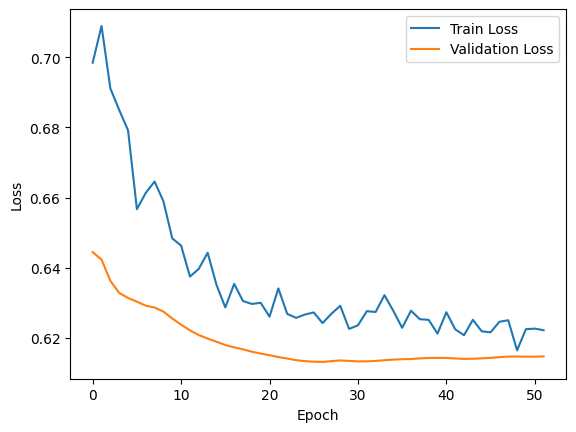

Test Accuracy for Vegas Correct: 0.6571
Assuming Vegas Correct Test Accuracy: 0.6571


In [48]:
from sklearn.model_selection import train_test_split

TARGET = "Vegas Correct"
X = data.drop([TARGET, "Home Team Win"]).to_numpy()
y = data.select(pl.col(TARGET)).to_numpy()
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
X_train = X_train.to(device)
X_val = X_val.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_val = y_val.to(device)
y_test = y_test.to(device)
model = SportsBettingModel(num_features=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, val_loss = train_model(model, epochs=1000)
plot_losses(train_loss, val_loss)
accuracy = test_model(model, X_test, y_test)
print(f"Test Accuracy for Vegas Correct: {accuracy:.4f}")

assume_vegas_correct = torch.ones_like(y_test, dtype=torch.float32).to(device)
accuracy_assume_vegas_correct = (assume_vegas_correct.cpu().numpy().flatten() == y_test.cpu().numpy().flatten()).mean()
print(f"Assuming Vegas Correct Test Accuracy: {accuracy_assume_vegas_correct:.4f}")

# Not Enough Data
It is clear that not much can be gained from a dataset that only contains Vegas predictions, even if we see the trends from open to close of how Vegas adjusts predictions. We should instead look to add additional data concerning the teams or games themselves